# **DATA integration with OpenVisus**

This notebook presents all the steps to visualize data with OpenVisus using SOMOSPIE as an example. 

### **DISCLAIMER:**
Please **DO NOT** post this notebook publicly. This notebook has write permission keys to cloud that we do not want to share publicly. The `dashboard.py` file can be shared with anyone.

## Step 1 - Dataset definition

The first step talks about the source of the data for this particular example, we are using the SOMOSPIE workflow with which we will generate the terrain parameters by state, the files generated by this workflow are images in Tiff format. Make sure you can run your existing SOMOSPIE workflow normally before proceeding. During the development, this notebook is located inside: `./GEOtiled_Refactor/geotiled_notebook`.


Once you have the workflow working properly, go back to `../somospie_lib/geotiled.py` (or whever it exists) and add a return statetement `return raster_array` to the existing function `generate_img`.

Now, install these libraries using pip:

`pip install xmldict requests colorcet bokeh panel aws awscli-plugin-endpoint OpenVisus==2.2.128`


These specific paths below are from Aashish's workflow and here for reference purposes only. Please remove them and add your own path here, if applicable, to prevent any errors. `somospie_lib/src` is the path to the somospie_lib that comes with the workflow. Contact UTK-GCLab team for any issues in `Step 1` and UUtah team for any issues in `Step 2-4`.

In [1]:
import os,sys
sys.path.append('/home/aashish/PhD/Somospie/Src_SOMOSPIE-jay_dev/GEOtiled_Refactor/somospie_lib/src')
sys.path.append('/home/aashish/miniconda3/envs/geotiled/lib/python3.12/site-packages')

In [2]:
from somospie_lib import geotiled as gt
from somospie_lib import geoextras as ge
from pathlib import Path
import glob
import os, shutil
import shutil
import time
import multiprocessing
import matplotlib.pyplot as plt
import OpenVisus as ov
import numpy as np
start_time=time.time()

#To silence a deprecation warning. 
gt.gdal.UseExceptions()

/home/aashish/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
download_list = "./download_urls.txt" #Where the list of download links will be stored
root_output_folder = './geotiled/' #root folder where geotiled will store data
n_tiles = 16 #Number of tiles that are generated for parameter computation
dem_tiles_dir_name = "tiles" #Folder where downloaded DEM tiles will be saved
param_tiles_dir_name = "elevation_tiles" #Folder where computation tiles will be saved. 
gcs_name = "gcs.tif" #Name for the mosaicked DEM
pcs_name = "pcs.tif" #Name for the projected DEM
shapefile = ["../misc_data/shp_files/TN/STATEFP_47.shp"] #Shapefile for Visualization
region_bounding_box = {"xmin": -90.4,"ymin": 34.8,"xmax": -81.55,"ymax": 36.8} #For `fetch_dem`. X=Longitude Y=Latitude. Determine bounding coordinates by looking at a map.

In [4]:
#Fetching Data
tiles_folder = os.path.join(root_output_folder, dem_tiles_dir_name)
Path(root_output_folder).mkdir(parents=True, exist_ok=True)
Path(tiles_folder).mkdir(parents=True, exist_ok=True)

#Setting up for parameter computation
gcs = os.path.join(root_output_folder,gcs_name)
pcs = os.path.join(root_output_folder,pcs_name)
elevation_tiles = os.path.join(root_output_folder, param_tiles_dir_name)
Path(elevation_tiles).mkdir(parents=True, exist_ok=True)

#Computing Parameters
aspect_tiles = os.path.join(root_output_folder, 'aspect_tiles')
hillshading_tiles = os.path.join(root_output_folder, 'hillshading_tiles')
slope_tiles = os.path.join(root_output_folder, 'slope_tiles')
Path(aspect_tiles).mkdir(parents=True, exist_ok=True)
Path(hillshading_tiles).mkdir(parents=True, exist_ok=True)
Path(slope_tiles).mkdir(parents=True, exist_ok=True)

In [5]:
gt.fetch_dem(bbox=region_bounding_box,txtPath=download_list, dataset="National Elevation Dataset (NED) 1 arc-second Current")
gt.download_files(download_list, tiles_folder)

./download_urls.txt


Downloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [02:36<00:00, 11.0MB/s]


In [6]:
raster_list = glob.glob(tiles_folder + '/*')

gt.build_mosaic(raster_list, gcs)

# Optional: delete all tiles after building mosaic.
shutil.rmtree(tiles_folder)
# Optional: remove vertex data file. 
os.remove("./merged.vrt")

0...10...20...30...40...50...60...70...80...90...

In [7]:
gt.reproject(gcs, pcs, "EPSG:9822")

# Optional: Remove mosaicked DEM. 
os.remove(gcs)

100 - done.
0...10...20...30...40..

In [8]:
gt.crop_into_tiles(pcs, elevation_tiles, n_tiles)

glob_of_tiles = glob.glob(elevation_tiles + '/*.tif')

.50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90..

In [9]:
pool = multiprocessing.Pool(processes=n_tiles) 
pool.map(gt.compute_geotiled, sorted(glob.glob(elevation_tiles + '/*.tif')))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [10]:
gt.build_mosaic_filtered(sorted(glob.glob(aspect_tiles + '/*.tif')), os.path.join(root_output_folder, 'aspect.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(hillshading_tiles + '/*.tif')), os.path.join(root_output_folder,'hillshading.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(slope_tiles + '/*.tif')), os.path.join(root_output_folder, 'slope.tif'))


shutil.rmtree(aspect_tiles)
shutil.rmtree(hillshading_tiles)
shutil.rmtree(slope_tiles)
shutil.rmtree(elevation_tiles)

Reprojecting..
.100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...Cropping with combined shapefiles...
60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)


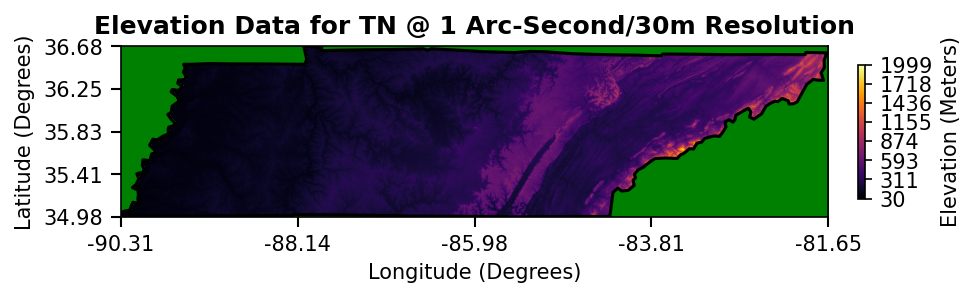

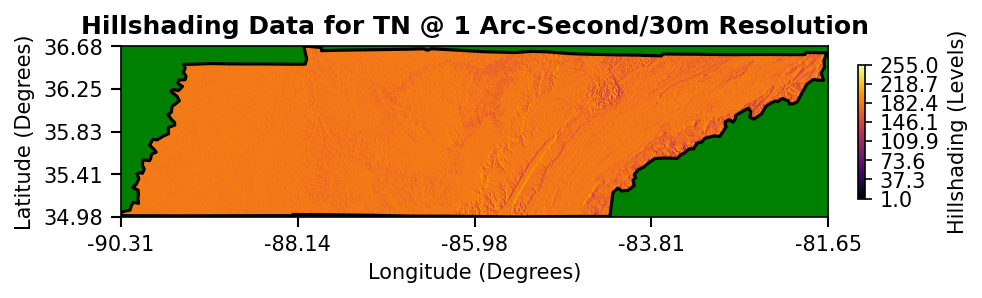

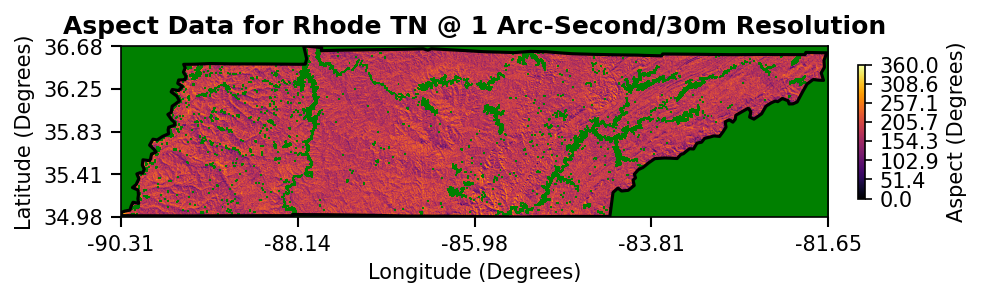

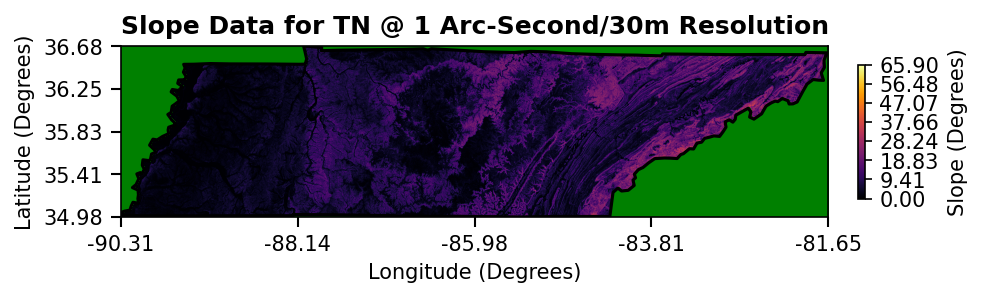

In [11]:
hill = os.path.join(root_output_folder, 'hillshading.tif')
aspect = os.path.join(root_output_folder, 'aspect.tif')
slope = os.path.join(root_output_folder, 'slope.tif')


pcs_array=gt.generate_img(pcs,    downsample=5, reproject_gcs=True, shp_files=shapefile, title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",    zunit="Meter",   xyunit="Degree", ztype="Elevation",   crop_shp=True) 
hill_array=gt.generate_img(hill,   downsample=5, reproject_gcs=True, shp_files=shapefile, title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",  zunit="Level",   xyunit="Degree", ztype="Hillshading", crop_shp=True)
aspect_array=gt.generate_img(aspect, downsample=5, reproject_gcs=True, shp_files=shapefile, title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution", zunit="Degree",  xyunit="Degree", ztype="Aspect",      crop_shp=True)
slope_array=gt.generate_img(slope,  downsample=5, reproject_gcs=True, shp_files=shapefile, title="Slope Data for TN @ 1 Arc-Second/30m Resolution",        zunit="Degree",  xyunit="Degree", ztype="Slope",       crop_shp=True)

## Step 2 - Conversion to IDX
Once the data is generated, it must be converted into the IDX format so that it can be read by OpenVisus. 
Here, we are only creating one single idx file, and including all these variables as fields.

Now, for all fields of idx, we are writing the corresponding data. `Fields` should be in this format: [ov.Field(FIELD_NAME, DTYPE)]


After writing, we are compressing this with `zip` compression.

Note: If this was a timeseries data, we were supposed to set the endtime in time=[0,end_time,"%0000d/"], and write the corresponding data to each timestep just like the fields.

In [44]:
if not os.path.exists('idx_data'):
    os.mkdir('idx_data')
os.chdir('idx_data')
filename='Tennessee_terrain_parameters.idx'
all_fields=[ov.Field('elevation', 'float32'),ov.Field('hillshading', 'uint8'),ov.Field('aspect', 'float32'),ov.Field('slope', 'float32')]
input_data=[np.flipud(pcs_array).copy(),np.flipud(hill_array).copy(),np.flipud(aspect_array).copy(),np.flipud(slope_array).copy()]
height,width=input_data[0].shape
db=ov.CreateIdx(url=filename,dims=[width,height],fields=all_fields,arco='4mb',time=[0,0,"%00000d/"])
i=0
for fld in db.getFields():
    db.write(input_data[i],field=fld)
    i+=1
db.compressDataset(['zip'])

### Step 2.1 - Publishing files to Seal Storage

In this additional step we are publishing the files to seal storage to store the data generated by this particular workflow, Seal Storage works with buckets and to publish the files we use the AWS CLI tool to synchronize the folder. Make sure you have write access to the s3 buckets.

Contact AASHISH PANTA or HEBERTH MARTINEZ for aws `config` and `credentials` files. They should go in `.aws` folder in your home directory. These are standard steps for AWS usage.


**DO NOT copy data to directories other than s3://utah/nsdf/**

In [45]:
filename='Tennessee_terrain_parameters.idx'
HOME_DIR="s3://utah/nsdf/somospie/" # DONOT change this line
data_dir= "terrain_tennessee/"
upload_dir=HOME_DIR + data_dir
s3_path=upload_dir.split("://")[1]
s3_path+=filename
s3_path

'utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters.idx'

In [46]:
!aws s3 --profile sealstorage --no-verify-ssl sync .  {upload_dir}

/home/aashish/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maritime.sealstorage.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/aashish/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maritime.sealstorage.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
upload: ./Tennessee_terrain_parameters.idx to s3://utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters.idx
/home/aashish/miniconda3/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'maritime.sealstorage.io'. Adding certificate verificati

## Step 3 - Load IDX with OpenVisus

In this step, we download the files from Seal Storage and run OpenVisus to load and visualize the data for testing.

This is caching the data to `user's home directory` under `visus` folder for faster reload. If you don't want to cache the data, and want to load data directly from cloud every time, just remove `&cahced=arco` from the link below! 

If you are frequently changing the data and syncing it to cloud without changing the filename, please remove the cache part from the link.

In [67]:
from OpenVisus import *
import numpy as np
import matplotlib.pyplot as plt

In [68]:
remote_dir='https://maritime.sealstorage.io/api/v0/s3/'+s3_path+'?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco'
remote_dir

'https://maritime.sealstorage.io/api/v0/s3/utah/nsdf/somospie/terrain_tennessee/Tennessee_terrain_parameters.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco'

In [69]:
db=LoadDataset(remote_dir)

In [70]:
read_elevation=db.read(field='elevation')
read_hillshading=db.read(field='hillshading')
read_aspect=db.read(field='aspect')
read_slope=db.read(field='slope')

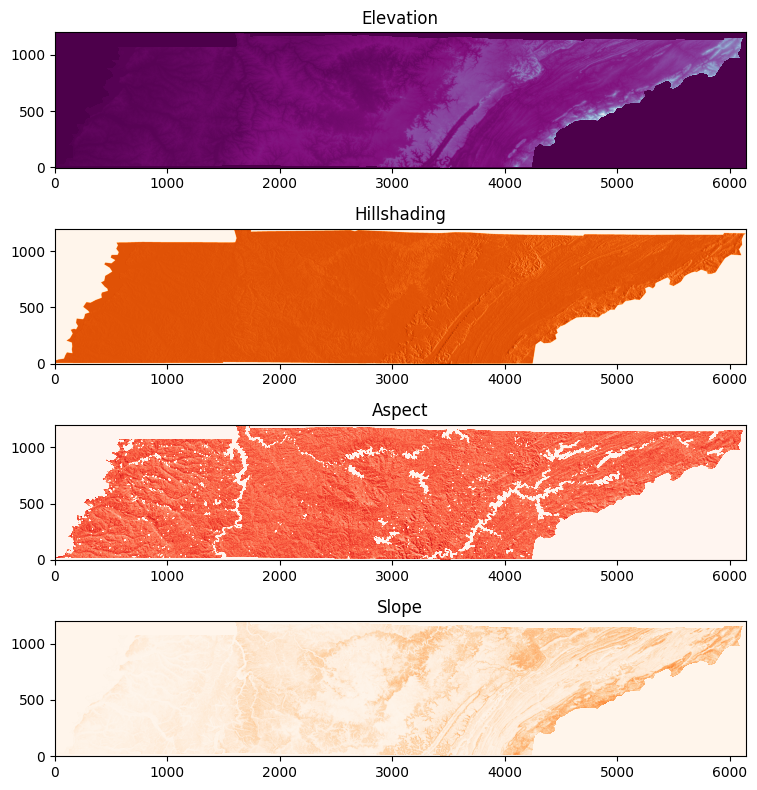

In [71]:
fig,axs=plt.subplots(4,1,figsize=(10,8))
axs[0].imshow(read_elevation,origin='lower',vmin=30,vmax=1999,cmap='BuPu_r')
axs[0].set_title('Elevation')
axs[1].imshow(read_hillshading,origin='lower',vmin=0,vmax=255,cmap='Oranges')
axs[1].set_title('Hillshading')

axs[2].imshow(read_aspect,vmin=0,origin='lower',vmax=360,cmap='Reds')
axs[2].set_title('Aspect')

axs[3].imshow(read_slope,vmin=0,origin='lower',vmax=65.9,cmap='Oranges')
axs[3].set_title('Slope')
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.tight_layout()
plt.show()

## Step 4 - Create a dashboard with OpenVisus

### To run the dashboard, do the following: 

- First, make sure you can see the visualization above. 

- Run `setup_openvisuspy.sh` 

- Copy the *remote_dir* variable and replace it in dashboard.py file. 

- Run this command: `python3 -m bokeh serve --port 8989 dashboard.py`

Now, you can go to `localhost:8989` to see the dashboard!

*Suggestions:*
- In the dashboard, the `palette range` adjusts according to min/max of the data. Select `User` in `Range` and update accordingly, or select `dynamic` and switch back to  `User` to retain and update either of min/max values.
- More updates in the future will fix this issue.